In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# 1. Генерация нормального распределения

In [2]:
def sample_normal(n=1, mu=0, sigma=1, k=30):
    #сумма из k случайных равномерно распределенных величин
    uniform_sum = np.random.uniform(low=0.0, high=1.0, size=(n, k)).sum(axis=1)
    #нормализация таким образом, чтобы среднее было 0 и std - единицей
    normalized = (uniform_sum - k * 0.5) / np.sqrt(k / 12)
    #сдвиг среднего и std
    return mu + sigma * normalized

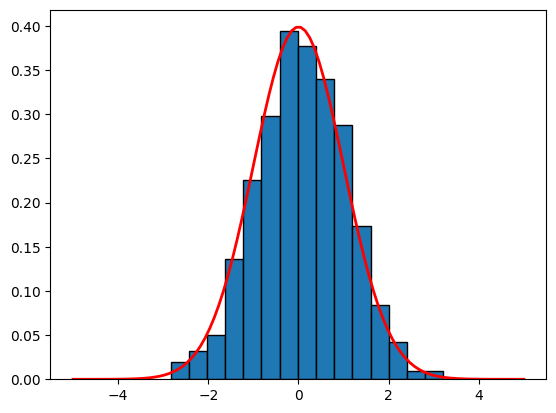

In [11]:
data = sample_normal(n=1000)

x = np.linspace(-5, 5, 100)
p = stats.norm.pdf(x, 0, 1)
plt.hist(data, edgecolor='black', density=True, bins=15)
plt.plot(x, p, c='r', lw=2)

## 1.1 Тест на нормальность критерием Пирсона

In [13]:
ks = [3, 30, 300, 3000, 30000, 300000]

for k in ks:
    print(f'k = {k}')

    data = sample_normal(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)
    
    cdf = stats.norm.cdf(bin_edges, loc=0, scale=1)
    expected_freq = len(data) * np.diff(cdf)
    expected_freq *= observed_freq.sum() / expected_freq.sum()
    
    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=2)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 3
Статистика χ²: 6.817744696223139
p-value: 0.44809989905226755

k = 30
Статистика χ²: 6.631510753504206
p-value: 0.4682273846098506

k = 300
Статистика χ²: 2.8103177198513127
p-value: 0.9019774298594616

k = 3000
Статистика χ²: 12.718460763545304
p-value: 0.0792724808163425

k = 30000
Статистика χ²: 7.001150677272728
p-value: 0.4287600591425393

k = 300000
Статистика χ²: 13.142867653638657
p-value: 0.06870301714281768



## 1.2 Тест на нормальность с помощью анаморфоз

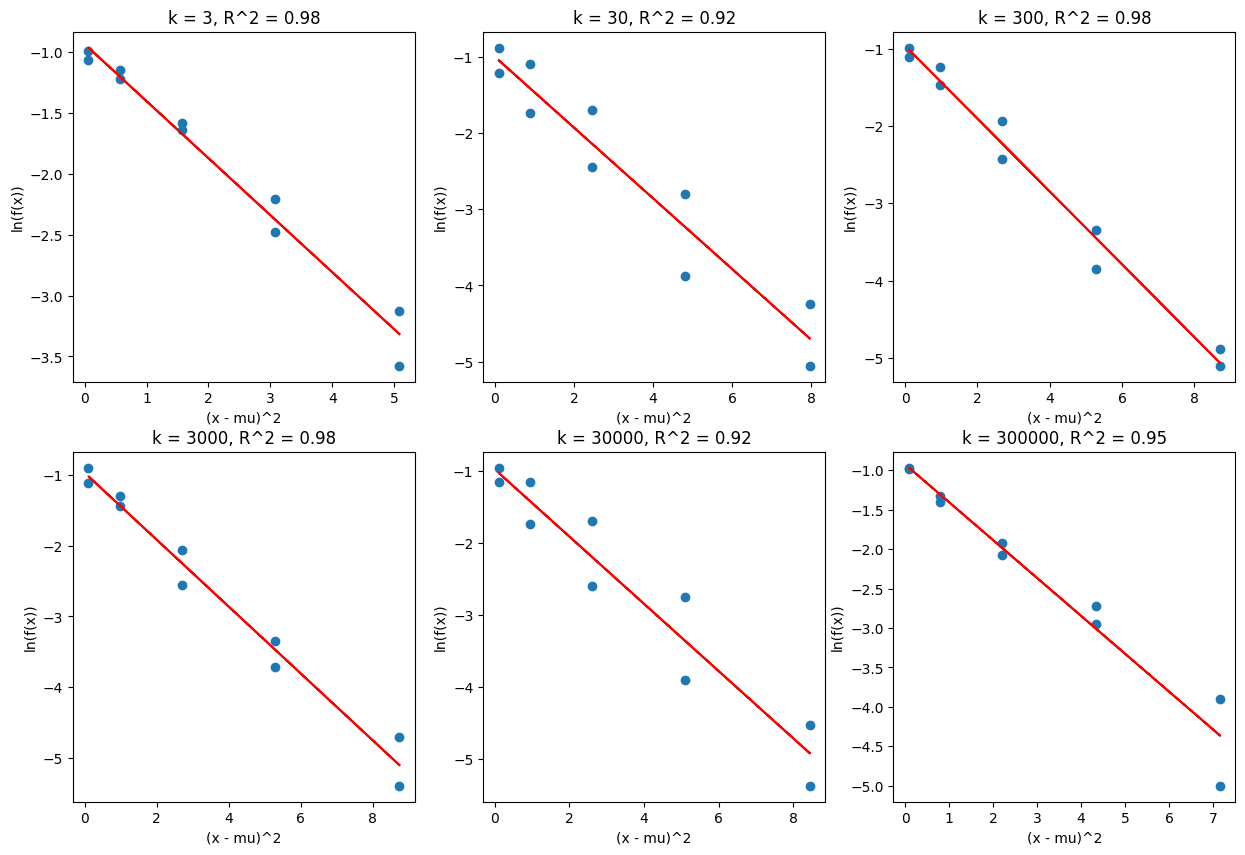

In [15]:
ks = [3, 30, 300, 3000, 30000, 300000]

fig, axs = plt.subplots(2, len(ks) // 2, figsize=(15, 10))

axs = axs.ravel()

for i, k in enumerate(ks):
    data = sample_normal(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    log_density = np.log(observed_freq)

    valid_idx = np.isfinite(log_density)
    x_valid = bin_centers[valid_idx]
    y_valid = log_density[valid_idx]

    x_mean = x_valid.mean()

    x_transformed = ((x_valid - x_mean) ** 2).reshape(-1, 1)
    lin_reg = LinearRegression().fit(x_transformed, y_valid)

    axs[i].scatter(x_transformed, y_valid)
    axs[i].plot(x_transformed, lin_reg.predict(x_transformed), color='red')
    axs[i].set_title(f"k = {k}, R^2 = {lin_reg.score(x_transformed, y_valid):.2f}")
    
    axs[i].set_xlabel("(x - mu)^2")
    axs[i].set_ylabel("ln(f(x))")

# 2. Генерация распределения $\chi^2$

In [16]:
def sample_chi2(n=1, k=1):
    return np.array([(sample_normal(n=k) ** 2).sum() for _ in range(n)])

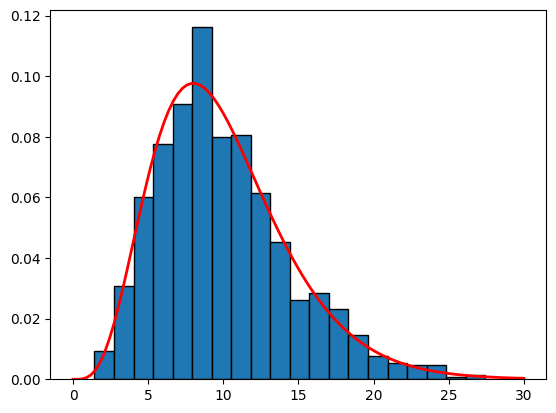

In [19]:
data = sample_chi2(n=1000, k=10)

x = np.linspace(0, 30, 100)
p = stats.chi2.pdf(x, 10)
plt.hist(data, edgecolor='black', density=True, bins=20)
plt.plot(x, p, c='r', lw=2)

## 2.1 Тест на $\chi^2$ распределение с помощью критерия Пирсона

In [20]:
ks = [1, 3, 5, 10]

for k in ks:
    print(f'k = {k}')

    data = sample_chi2(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.chi2.cdf(bin_edges, df=k)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=1)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 1
Статистика χ²: 10.026918515210818
p-value: 0.26314167035792785

k = 3
Статистика χ²: 131.50883617308764
p-value: 1.376585070786199e-24

k = 5
Статистика χ²: 13.646366534866516
p-value: 0.09146126546077978

k = 10
Статистика χ²: 3.16808641003679
p-value: 0.9233704152292074



# 3. Генерация распределения Фишера

In [21]:
def sample_f(n=1, d1=1, d2=1):
    return np.array([(sample_chi2(k=d1) / d1) / (sample_chi2(k=d2) / d2) for _ in range(n)])

(-0.5, 10.0)

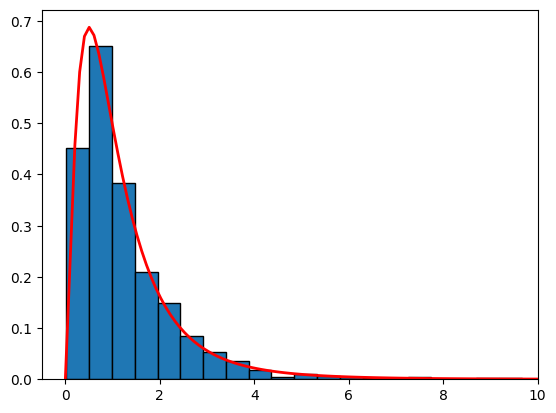

In [22]:
data = sample_f(n=1000, d1=5, d2=10)

x = np.linspace(0, 10, 100)
p = stats.f.pdf(x, 5, 10)
plt.hist(data, edgecolor='black', density=True, bins=20)
plt.plot(x, p, c='r', lw=2)
plt.xlim((-0.5, 10))

## 3.1 Тест на распределение Фишера с помощью критерия Пирсона

In [23]:
ds = [(6, 60), (40, 20), (5, 5)]

for d1, d2 in ds:
    print(f'd1 = {d1}, d2 = {d2}')

    data = sample_f(1000, d1, d2)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.f.cdf(bin_edges, d1, d2)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=2)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

d1 = 6, d2 = 60
Статистика χ²: 12.991314917046074
p-value: 0.07232028440200226

d1 = 40, d2 = 20
Статистика χ²: 6.573481527810155
p-value: 0.47459562655485266

d1 = 5, d2 = 5
Статистика χ²: 10.559540521312453
p-value: 0.15901891122574058



# 4. Генерация t распределения

In [25]:
def sample_t(n=1, k=2):
    return np.array([sample_normal() / ((sample_normal(n=k) ** 2).mean() ** 0.5) for _ in range(n)])

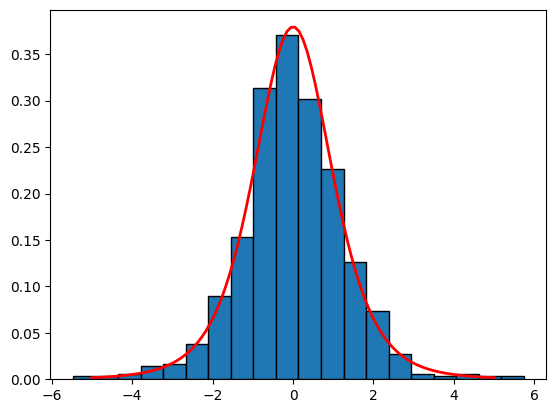

In [26]:
data = sample_t(n=1000, k=5)

x = np.linspace(-5, 5, 100)
p = stats.t.pdf(x, 5)
plt.hist(data, edgecolor='black', density=True, bins=20)
plt.plot(x, p, c='r', lw=2)

# 4.1 Тест на t распределение с помощью критерия Пирсона

In [27]:
ks = [3, 5, 9]

for k in ks:
    print(f'k = {k}')

    data = sample_t(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.t.cdf(bin_edges, df=k)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=1)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 3
Статистика χ²: 7.844947883118146
p-value: 0.44876095447448505

k = 5
Статистика χ²: 10.95272514094485
p-value: 0.20439227442912683

k = 9
Статистика χ²: 10.556560199158335
p-value: 0.22811239195002656

